# <center>Image Matching Challenge Kaggle 22928</center>

<center><img src="./images/challange.gif"></center>

# Overview
The process to reconstruct 3D objects and buildings from images is called Structure-from-Motion (SfM). Typically, these images are captured by skilled operators under controlled conditions, ensuring homogeneous, high-quality data. It is much more difficult to build 3D models from assorted images, given a wide variety of viewpoints, lighting and weather conditions, occlusions from people and vehicles, and even user-applied filters.

The first part of the problem is to identify which parts of two images capture the same physical points of a scene, such as the corners of a window. This is typically achieved with local features (key locations in an image that can be reliably identified across different views). Local features contain short description vectors that capture the appearance around the point of interest. By comparing these descriptors, likely correspondences can be established between the pixel coordinates of image locations across two or more images. This "image registration" makes it possible to recover the 3D location of the point by triangulation.

**Goal:**

In this competition, we'll create a machine learning algorithm that registers two images from different viewpoints. With access to a dataset of thousands of images to train and test our model in order to achieve the highest accuracy possible.

# Table of Contents

A. [Used Libraries](#bibliotheque)<br>
B. [Feature Matchers](#feature-matchers)<br>
   B1. [LoFTR](#loftr)<br>
   B2. [SuperGlue](#superglue)<br>
   B3. [QuadTree](#quadtree)<br>
   B4. [Unified Model](#unified)<br>
   B.5 [Pickle and Unpickle Model](#pickle)<br>
C. [Predict Fundamental Matrix and Calculate mAA](#predict-fundamental-matrix)<br>

## A. Used Libraries

<a id="bibliotheque"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import torch
import random
import csv
from abc import ABC, abstractmethod
from utils import (ReadCSVData, FlattenMatrix, ComputeFundamentalMatrix, EvaluatePredVSGroundTruth, extract_zip,
                   DrawMatches, seed_torch, ImageSize, NumPairs, load_and_preprocess_images, process_images)
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
src = os.path.join(os.getcwd(), 'input')

# seed for reproducibility - https://pytorch.org/docs/stable/notes/randomness.html
seed_torch()

## B. Feature Matchers

<a id="feature-matchers"></a>

In [2]:
class FeatureMatcher(ABC):
    def __init__(self):
        super().__init__()

    @abstractmethod
    def match(self, img_path0, img_path1):
        pass

### B1. LoFTR

<a id="loftr"></a>

[LoFTR](https://github.com/zju3dv/LoFTR) is a novel method for local image feature matching. Instead of performing image feature detection, description, and matching sequentially, we propose to first establish pixel-wise dense matches at a coarse level and later refine the good matches at a fine level. In contrast to dense methods that use cost volume to search correspondences, we use self and cross attention layers in Transformers to obtain feature descriptors that are conditioned on both images. The global receptive field provided by Transformers enables our method to produce dense matches in low-texture areas, where feature detectors usually struggle to produce repeatable interest points. The experiments on indoor and outdoor datasets show that LoFTR outperforms state-of-the-art methods by a large margin. LoFTR also ranks first on two public benchmarks of visual localization among the published methods. <br><br>

<center><img src="./images/loftr.png" width="500" height="300"></center>

In [3]:
!mkdir models
%cd models/
!git clone https://github.com/zju3dv/LoFTR --depth 1
%cd ..

!mkdir weights 
%cd weights/
!gdown --id 1v4Mz-LQ_DvMx6u0J8ItVDWUn6VdKog0r
!gdown --id 12DKwALuM8o0kUhUwMqXc9mHetewxe6GP
%cd ..

C:\Users\barbe\Downloads\maman_19\models
C:\Users\barbe\Downloads\maman_19


Cloning into 'LoFTR'...


C:\Users\barbe\Downloads\maman_19\weights


C:\Users\barbe\Downloads\maman_19\base\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1v4Mz-LQ_DvMx6u0J8ItVDWUn6VdKog0r
From (redirected): https://drive.google.com/uc?id=1v4Mz-LQ_DvMx6u0J8ItVDWUn6VdKog0r&confirm=t&uuid=b26d78c4-8187-43a8-a98a-920257e48a9f
To: C:\Users\barbe\Downloads\maman_19\weights\loftr_outdoor.ckpt

  0%|          | 0.00/46.3M [00:00<?, ?B/s]
  1%|1         | 524k/46.3M [00:00<00:25, 1.80MB/s]
  5%|4         | 2.10M/46.3M [00:00<00:07, 5.91MB/s]
 10%|#         | 4.72M/46.3M [00:00<00:03, 11.6MB/s]
 17%|#6        | 7.86M/46.3M [00:00<00:02, 17.1MB/s]
 24%|##3       | 11.0M/46.3M [00:00<00:01, 20.6MB/s]
 31%|###       | 14.2M/46.3M [00:00<00:01, 22.7MB/s]
 37%|###7      | 17.3M/46.3M [00:00<00:01, 24.2MB/s]
 44%|####4     | 20.4M/46.3M [00:01<00:01, 24.9MB

C:\Users\barbe\Downloads\maman_19


C:\Users\barbe\Downloads\maman_19\base\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=12DKwALuM8o0kUhUwMqXc9mHetewxe6GP
From (redirected): https://drive.google.com/uc?id=12DKwALuM8o0kUhUwMqXc9mHetewxe6GP&confirm=t&uuid=77d7f789-eaf0-4ea1-8a29-1aaba3327047
To: C:\Users\barbe\Downloads\maman_19\weights\quadtree_outdoor.ckpt

  0%|          | 0.00/153M [00:00<?, ?B/s]
  0%|          | 524k/153M [00:00<01:19, 1.91MB/s]
  1%|1         | 1.57M/153M [00:00<00:34, 4.44MB/s]
  2%|2         | 3.15M/153M [00:00<00:20, 7.15MB/s]
  3%|3         | 4.72M/153M [00:00<00:16, 8.81MB/s]
  4%|4         | 6.29M/153M [00:00<00:14, 10.1MB/s]
  5%|5         | 7.86M/153M [00:00<00:13, 10.9MB/s]
  6%|6         | 9.44M/153M [00:01<00:12, 11.9MB/s]
  7%|7         | 11.0M/153M [00:01<00:12, 11.3MB/s]
  

In [4]:
from models.LoFTR.src.loftr import LoFTR, default_cfg

class LoFTRMatcher(FeatureMatcher):
    def __init__(self):
        super().__init__()
        
        # robust and efficient model for visual estimation in image matching
        self.matcher = LoFTR(config=default_cfg)
        # loads pretrained weights into the matcher model
        filename = os.path.join('weights', 'loftr_outdoor.ckpt')
        self.matcher.load_state_dict(torch.load(filename, map_location=device)['state_dict'])
        # move the model to device
        self.matcher = self.matcher.to(device).eval()

    def match(self, img_path0, img_path1):
        batch, (w1, h1), (w2, h2), img0, img1 = load_and_preprocess_images(img_path0, img_path1, ImageSize.max_img_size_loftr.value, squaring=True)
        
        with torch.no_grad():
            self.matcher(batch)
        
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf'].cpu().numpy()
            
        mkpts0, mkpts1 = process_images(mkpts0, mkpts1, mconf, w1, h1, w2, h2, img0, img1, NumPairs.max_num_pairs_loftr.value)
        
        return mkpts0, mkpts1

### B2. SuperGlue

<a id="superglue"></a>

[SuperGlue](https://github.com/magicleap/SuperGluePretrainedNetwork) network is a Graph Neural Network combined with an Optimal Matching layer that is trained to perform matching on two sets of sparse image features. This repo includes PyTorch code and pretrained weights for running the SuperGlue matching network on top of SuperPoint keypoints and descriptors. Given a pair of images, you can use this repo to extract matching features across the image pair.<br><br>

<center><img src="./images/superglue.png" width="500" height="300"></center>

In [5]:
%cd models/
!git clone https://github.com/magicleap/SuperGluePretrainedNetwork --depth 1
%cd ..

C:\Users\barbe\Downloads\maman_19\models
C:\Users\barbe\Downloads\maman_19


Cloning into 'SuperGluePretrainedNetwork'...


In [6]:
from models.SuperGluePretrainedNetwork.models.matching import Matching

# Implementation of SuperGlue
class SuperGlueMatcher(FeatureMatcher):
    def __init__(self):
        super().__init__()
        
        # config values from: https://github.com/magicleap/SuperGluePretrainedNetwork?tab=readme-ov-file#running-on-sample-outdoor-pairs
        config = {
            'superpoint': {
                'nms_radius': 3,
                'keypoint_threshold': 0.005,
                'max_keypoints': 2048
            },
            'superglue': {
                'weights': 'outdoor',
                'sinkhorn_iterations': 20,
                'match_threshold': 0.2,
            }
        }
        self.matcher = Matching(config).eval().to(device)

    def match(self, img_path0, img_path1):        
        batch, (w1, h1), (w2, h2), img0, img1 = load_and_preprocess_images(img_path0, img_path1, ImageSize.max_img_size_superglue.value, squaring=False)
       
        with torch.no_grad():
            pred = self.matcher(batch)
        pred = {key: val[0].detach().cpu().numpy() for key, val in pred.items()}
        
        mkpts0, mkpts1 = pred['keypoints0'], pred['keypoints1']
        matches = pred['matches0']
        mconf = pred['matching_scores0']
    
        is_valid = matches != -1
        mkpts0 = mkpts0[is_valid]
        mkpts1 = mkpts1[matches[is_valid]]
        mconf = mconf[is_valid]
        
        mkpts0, mkpts1 = process_images(mkpts0, mkpts1, mconf, w1, h1, w2, h2, img0, img1, NumPairs.max_num_pairs_superglue.value)
    
        return mkpts0, mkpts1

### B3. QuadTree

<a id="quadtree"></a>

[QuadTree](https://github.com/magicleap/SuperGluePretrainedNetwork) reduces the computational complexity from quadratic to linear. Our quadtree transformer builds token pyramids and computes attention in a coarse-to-fine manner. At each level, the top K patches with the highest attention scores are selected, such that at the next level, attention is only evaluated within the relevant regions corresponding to these top K patches. We demonstrate that quadtree attention achieves state-of-the-art performance in various vision tasks, e.g. with 4.0% improvement in feature matching on ScanNet, about 50% flops reduction in stereo matching, 0.4-1.5% improvement in top-1 accuracy on ImageNet classification, 1.2-1.8% improvement on COCO object detection, and 0.7-2.4% improvement on semantic segmentation over previous state-of-the-art transformers. <br><br>

<center><img src="./images/quadtree.png" width="500" height="300"></center>

In [7]:
%cd models/
!git clone https://github.com/Tangshitao/QuadTreeAttention --depth 1
%cd ..

C:\Users\barbe\Downloads\maman_19\models
C:\Users\barbe\Downloads\maman_19


Cloning into 'QuadTreeAttention'...


In [8]:
import sys
sys.path.append('models/QuadTreeAttention/FeatureMatching')

from yacs.config import CfgNode as CN
from models.QuadTreeAttention.FeatureMatching.configs.loftr.outdoor.loftr_ds_quadtree import cfg

class QuadTreeAttentionMatcher(FeatureMatcher):
    def __init__(self):
        super().__init__()

        def lower_config(qta_cfg):
            if not isinstance(qta_cfg, CN):
                return qta_cfg
            return {k.lower(): lower_config(v) for k, v in qta_cfg.items()}

        config = lower_config(cfg)["loftr"]
        
        with torch.no_grad():
            self.matcher = LoFTR(config=config)
            filename = os.path.join('weights', 'quadtree_outdoor.ckpt')
            self.matcher.load_state_dict(torch.load(filename, map_location=device, weights_only=False)['state_dict'], strict=False)
            self.matcher = self.matcher.eval().to(device)


    def match(self, img_path0, img_path1):
        batch, (w1, h1), (w2, h2), img0, img1 = load_and_preprocess_images(img_path0, img_path1, ImageSize.max_img_size_quadtree.value, squaring=True)
        
        with torch.no_grad():
            self.matcher(batch)
        
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf'].cpu().numpy()
            
        mkpts0, mkpts1 = process_images(mkpts0, mkpts1, mconf, w1, h1, w2, h2, img0, img1, NumPairs.max_num_pairs_quadtree.value)
        
        return mkpts0, mkpts1

### B.4 Unified Model

In [9]:
# UnifiedFeatureMatcher Model
class Model(FeatureMatcher):
    def __init__(self, matchers):
        super().__init__()
        self.matchers = matchers

    def match(self, img_path0, img_path1):
        mkpts0_lst, mkpts1_lst = [], []

        for matcher in self.matchers:
            mkpts0, mkpts1 = matcher.match(img_path0, img_path1)
            mkpts0_lst.append(mkpts0)
            mkpts1_lst.append(mkpts1)

        mkpts0_combined = np.vstack(mkpts0_lst)
        mkpts1_combined = np.vstack(mkpts1_lst)

        return mkpts0_combined, mkpts1_combined
    
    def get_structure(self):
        print("Models Structure")
        for i, m in enumerate(self.matchers):
            print(f"Model: {m.__class__.__name__}")
            print(m.matcher.state_dict())
            print('-' * 50)
            
model = Model([LoFTRMatcher(), SuperGlueMatcher(), QuadTreeAttentionMatcher()])

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


### B.5 Pickle and Unpickle Model

In [10]:
import pickle

def save_model():
    with open(f'model.pkl', 'wb') as f:
        pickle.dump(model, f)


# TODO
def load_model():
    with open(f'model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
        loaded_model.get_structure()

save_model()

## C. Predict Fundamental Matrix and Calculate mAA

<a id="predict-fundamental-matrix"></a>

In [11]:
!gdown --id 1H7uUeQTpAuBABW-Qa3r2hzL3MoHHEHeN

C:\Users\barbe\Downloads\maman_19\base\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1H7uUeQTpAuBABW-Qa3r2hzL3MoHHEHeN
From (redirected): https://drive.google.com/uc?id=1H7uUeQTpAuBABW-Qa3r2hzL3MoHHEHeN&confirm=t&uuid=3af0347f-de1d-4679-8f30-94079edd01f6
To: C:\Users\barbe\Downloads\maman_19\input.zip

  0%|          | 0.00/755M [00:00<?, ?B/s]
  0%|          | 524k/755M [00:00<06:35, 1.91MB/s]
  0%|          | 2.10M/755M [00:00<02:03, 6.08MB/s]
  1%|          | 4.19M/755M [00:00<01:11, 10.6MB/s]
  1%|          | 6.82M/755M [00:00<00:50, 14.9MB/s]
  1%|1         | 9.44M/755M [00:00<00:42, 17.4MB/s]
  2%|1         | 12.6M/755M [00:00<00:36, 20.1MB/s]
  2%|2         | 15.2M/755M [00:00<00:34, 21.3MB/s]
  2%|2         | 17.8M/755M [00:01<00:34, 21.5MB/s]
  3%|2         | 20.4M

In [12]:
!mkdir input
        
extract_zip('input.zip', '.')

0it [00:00, ?it/s]

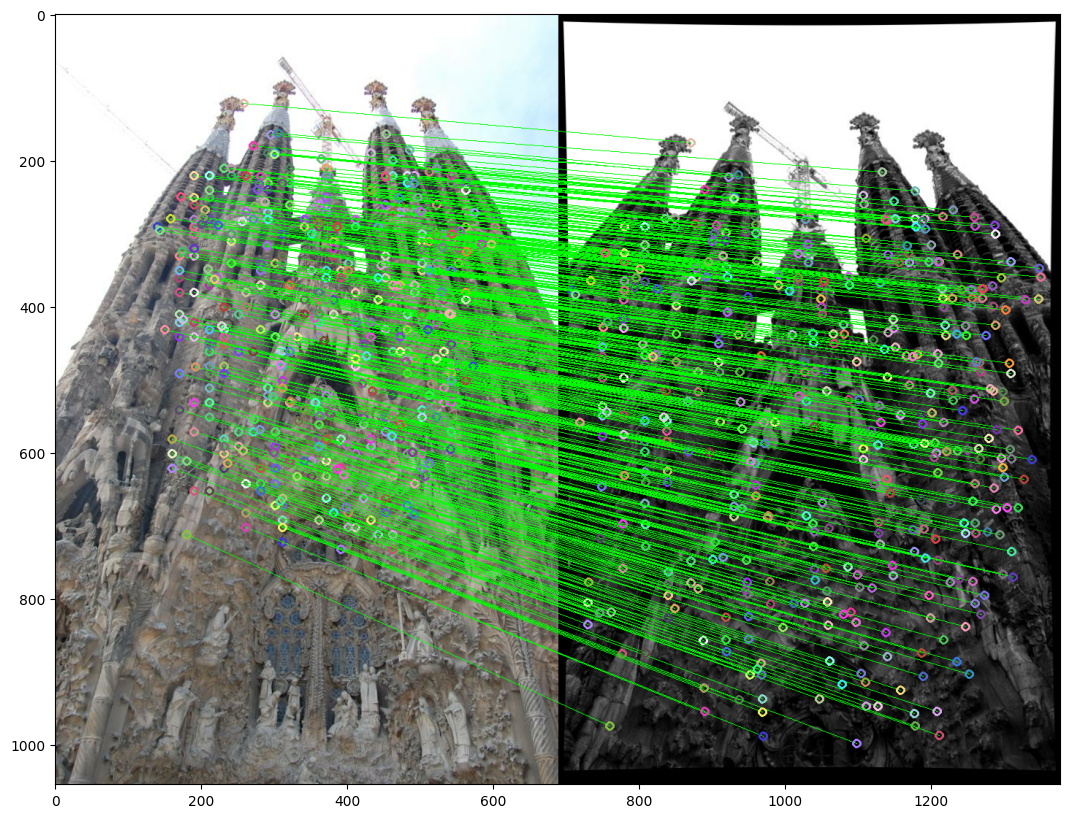

2it [00:48, 24.03s/it]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 285.74it/s]

------- SUMMARY -------
Mean average Accuracy on "sagrada_familia": 0.80000

Mean average Accuracy on dataset: 0.80000


In [21]:
def prediction_F_flattened(img1_path, img2_path):
    mkpts0, mkpts1 = model.match(img1_path, img2_path)
    F, inliers = ComputeFundamentalMatrix(mkpts0, mkpts1)
    F_flattened = FlattenMatrix(F)
    return F_flattened, mkpts0, mkpts1, inliers


def get_image_pairs(scene):
    filename = os.path.join(src, 'train', scene, 'pair_covisibility.csv')
    covisibility_dict = ReadCSVData(filename)
    pairs = [key for key, covis in covisibility_dict.items() if covis >= 0.1]
    random.shuffle(pairs)
    return pairs


def create_train_samples():
    train_samples = []
    filename = os.path.join(src, 'train', 'scaling_factors.csv')
    scaling_dict = ReadCSVData(filename)
    
    for scene_id, scene in enumerate(scaling_dict.keys()):
        pairs = get_image_pairs(scene)
        for pair in pairs:
            image_1_id, image_2_id = pair.split('-')
            image_1 = os.path.join(src, 'train', scene, 'images', f'{image_1_id}.jpg')
            image_2 = os.path.join(src, 'train', scene, 'images', f'{image_2_id}.jpg')
            train_samples.append([f'{scene};{pair}', None, image_1, image_2])
    return train_samples


def load_test_samples():
    test_samples = []
    filename = os.path.join(src, 'test.csv')
    with open(filename) as f:
        reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(reader):
            # skip header
            if i == 0:
                continue
            row[2] = os.path.join(src, 'test_images', row[1], f'{row[2]}.jpg')
            row[3] = os.path.join(src, 'test_images', row[1], f'{row[3]}.jpg')
            test_samples.append(row)
    
    return test_samples


def predict_fundamental_matrix(pairs):
    results = []
    for i, row in tqdm(enumerate(pairs)): 
        sample_id, _, image_1_id, image_2_id = row
        F_flattened, mkpts0, mkpts1, inliers = prediction_F_flattened(image_1_id, image_2_id)
        results.append({'sample_id': sample_id, 'fundamental_matrix': F_flattened})
        
        # first match only
        if i == 0:
            im1, im2 = cv2.imread(image_1_id), cv2.imread(image_2_id)
            DrawMatches(im1, im2, mkpts0, mkpts1, inliers)
            
    return pd.DataFrame(results)
        

def prediction(mode):
    # used for evaluating my model performance and calculate mAA
    if mode == "train":
        pairs = create_train_samples()
    # used for kaggle submission
    elif mode == "test":
        pairs = load_test_samples()
    else:
        raise ValueError(f"Invalid mode {mode}")
        
    return predict_fundamental_matrix(pairs)


mode = "train"
submission = prediction(mode)
submission.to_csv('submission.csv', index=False)

if mode == "train":
    filename = os.path.join(os.getcwd(), 'submission.csv')
    EvaluatePredVSGroundTruth(filename)